In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, activations
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, DenseNet201, InceptionResNetV2, ResNet50, ResNet101, InceptionV3, DenseNet121, EfficientNetB1
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2 as cv2
import sklearn.metrics as sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/Archive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/train/Benign/6078.jpg  
  inflating: __MACOSX/archive/train/Benign/._6078.jpg  
  inflating: archive/train/Benign/1717.jpg  
  inflating: __MACOSX/archive/train/Benign/._1717.jpg  
  inflating: archive/train/Benign/283.jpg  
  inflating: __MACOSX/archive/train/Benign/._283.jpg  
  inflating: archive/train/Benign/4647.jpg  
  inflating: __MACOSX/archive/train/Benign/._4647.jpg  
  inflating: archive/train/Benign/3128.jpg  
  inflating: __MACOSX/archive/train/Benign/._3128.jpg  
  inflating: archive/train/Benign/2236.jpg  
  inflating: __MACOSX/archive/train/Benign/._2236.jpg  
  inflating: archive/train/Benign/5559.jpg  
  inflating: __MACOSX/archive/train/Benign/._5559.jpg  
  inflating: archive/train/Benign/6050.jpg  
  inflating: __MACOSX/archive/train/Benign/._6050.jpg  
  inflating: archive/train/Benign/1059.jpg  
  inflating: __MACOSX/archive/train/Benign/._1059.jpg  
  inflating: archive/train/Benign/3896.jpg

In [4]:
train_path = '/content/archive/train'
test_path = '/content/archive/test'

In [5]:
class_names = ['Benign',"Malignant"]
class_labels = {}
for i, classes in enumerate(class_names, start=0):
  class_labels[classes] = i

print(class_labels)

{'Benign': 0, 'Malignant': 1}


In [6]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
  )
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_dataset = train_datagen.flow_from_directory(
train_path,
target_size=(150, 150),
batch_size=32,
class_mode='binary'
)

Found 11879 images belonging to 2 classes.


In [8]:
test_dataset = test_datagen.flow_from_directory(
test_path,
target_size=(150, 150),
batch_size=32,
class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [9]:
def create_resnet50_model():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
  model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1, activation='sigmoid')
  ])
  return model

In [17]:
def create_vgg16_model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
  model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1, activation='softmax')
  ])
  return model

In [18]:
def create_vgg19_model():
  base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150,150,3))
  model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1, activation='softmax')
  ])
  return model

In [22]:
models = [ create_resnet50_model(),create_vgg16_model(),
          create_vgg19_model()
          ]

for model in models:
  model.compile(
        loss='binary_crossentropy',
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy'])
  model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)      

In [23]:
histories = []
accuracies = []
recalls = []
precisions = []
f1_scores = []

for model in models:
    history = model.fit(
        train_dataset,
        epochs=6,
        validation_data=test_dataset
    )
    histories.append(history)

    loss, accuracy = model.evaluate(test_dataset)
    accuracies.append(accuracy)

    y_pred = model.predict(test_dataset)
    y_pred_binary = np.round(y_pred)

    precision = sklearn.precision_score(test_dataset.labels, y_pred_binary,zero_division=1)
    recall = sklearn.recall_score(test_dataset.labels, y_pred_binary,zero_division=1)
    f1 = sklearn.f1_score(test_dataset.labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

for i, model in enumerate(models):
    print(f"Model {i+1}:")
    print(f"  Precision: {precisions[i]}")
    print(f"  Recall: {recalls[i]}")
    print(f"  F1 Score: {f1_scores[i]}")


Epoch 1/6
372/372 [==============================] - 134s 282ms/step - loss: 0.4104 - accuracy: 0.8334 - val_loss: 1.0165 - val_accuracy: 0.5000
Epoch 2/6
372/372 [==============================] - 107s 287ms/step - loss: 0.3333 - accuracy: 0.8567 - val_loss: 1.4455 - val_accuracy: 0.5010
Epoch 3/6
372/372 [==============================] - 107s 286ms/step - loss: 0.3020 - accuracy: 0.8704 - val_loss: 2.4574 - val_accuracy: 0.5990
Epoch 4/6
372/372 [==============================] - 105s 281ms/step - loss: 0.2995 - accuracy: 0.8695 - val_loss: 0.5916 - val_accuracy: 0.6955
Epoch 5/6
372/372 [==============================] - 107s 286ms/step - loss: 0.2869 - accuracy: 0.8789 - val_loss: 0.3475 - val_accuracy: 0.8715
Epoch 6/6
63/63 [==============================] - 4s 55ms/step
Epoch 1/6
372/372 [==============================] - 112s 287ms/step - loss: 1.2731 - accuracy: 0.4706 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/6
372/372 [==============================] - 108s 289ms/st

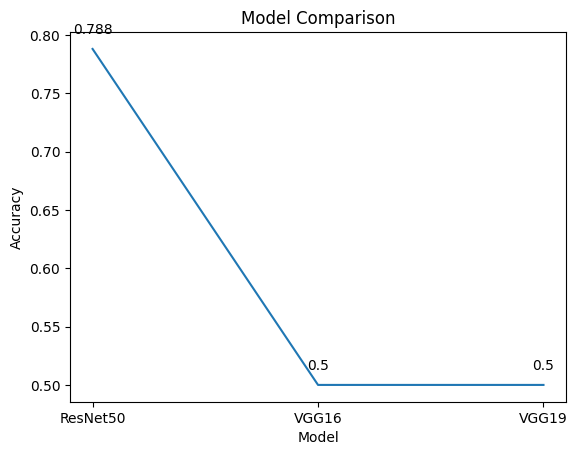

In [24]:
model_names = ['ResNet50', 'VGG16', 'VGG19']
plt.plot(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')

for i, v in enumerate(accuracies):
  plt.text(i, v + 0.01, str(round(v, 4)), ha='center', va='bottom')
plt.show()

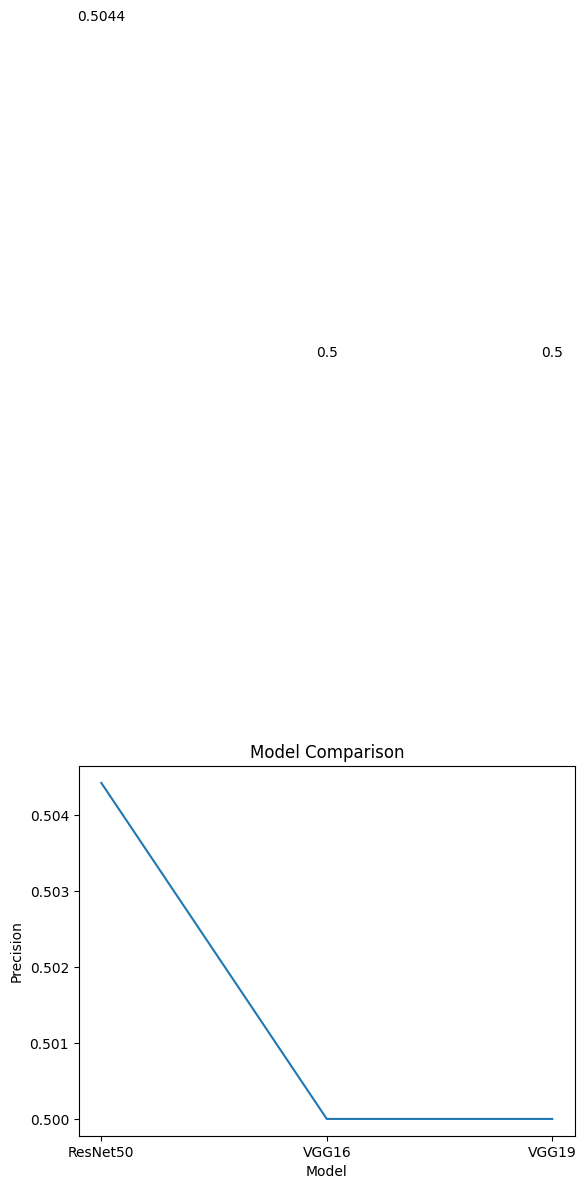

In [25]:
model_names = ['ResNet50', 'VGG16', 'VGG19']
plt.plot(model_names, precisions)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Model Comparison')

for i, v in enumerate(precisions):
  plt.text(i, v + 0.01, str(round(v, 4)), ha='center', va='bottom')
plt.show()

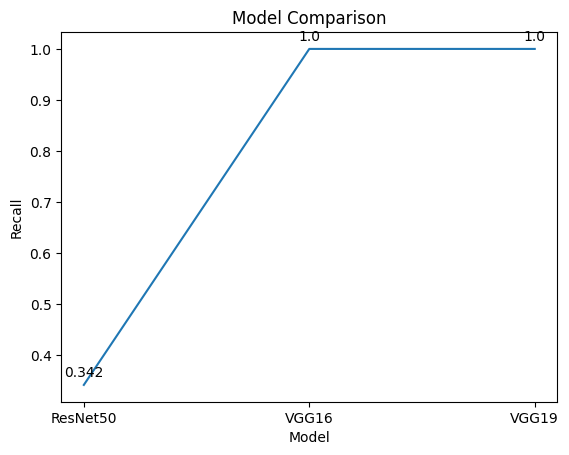

In [26]:
model_names = ['ResNet50', 'VGG16', 'VGG19']
plt.plot(model_names, recalls)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Model Comparison')

for i, v in enumerate(recalls):
  plt.text(i, v + 0.01, str(round(v, 4)), ha='center', va='bottom')
plt.show()

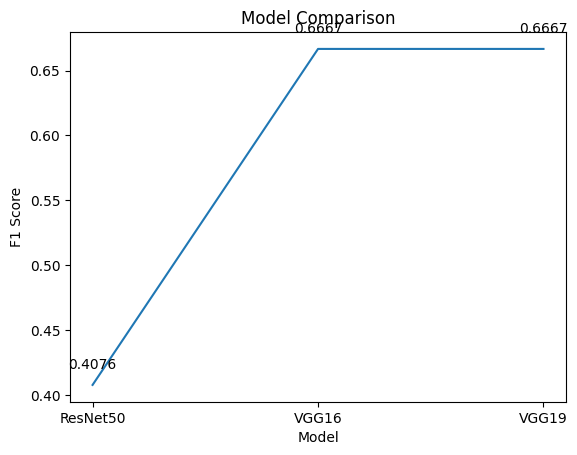

In [27]:
model_names = ['ResNet50', 'VGG16', 'VGG19']
plt.plot(model_names, f1_scores)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Model Comparison')

for i, v in enumerate(f1_scores):
  plt.text(i, v + 0.01, str(round(v, 4)), ha='center', va='bottom')
plt.show()